
# Code for Speed Optimization

In [2]:

import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


# Making fresh contents inside folders 

In [3]:
import shutil 
shutil.rmtree("/content/small_dataaset", ignore_errors=True)
shutil.rmtree("/content/small_train", ignore_errors=True)
shutil.rmtree("/content/small_val", ignore_errors=True)


# Extracting our Zip files.

In [4]:
import zipfile
import os

zip_path = "brain-tumor-mri-dataset.zip"          # uploaded file ka naam
extract_path = "/content/dataaset" # at whch directory
                                  # we have to extract
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction done! Files are in:", extract_path)

Extraction done! Files are in: /content/dataaset


In [5]:
print(os.listdir(extract_path))

['Testing', 'Training']


# Important libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

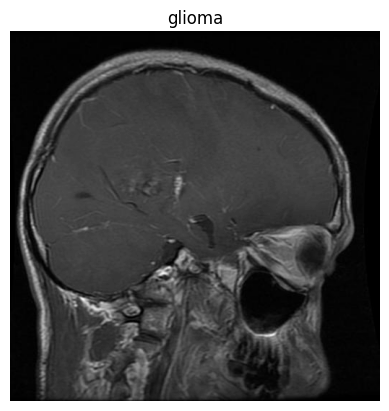

In [7]:
import os, random, matplotlib.pyplot as plt, matplotlib.image as mpimg
G = "/content/dataaset/Training/glioma"
for i in random.sample(os.listdir(G), 1):
    plt.imshow(mpimg.imread(os.path.join(G, i)), cmap='gray')
    plt.title("glioma")
    plt.axis('off')
    plt.show()


# Random Image Displaying From Every Class

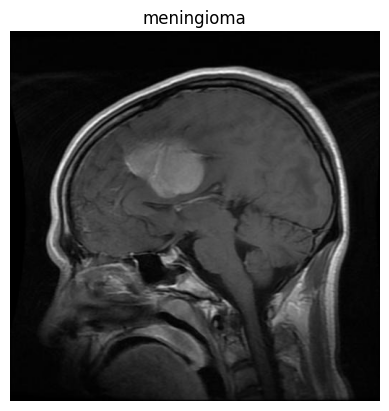

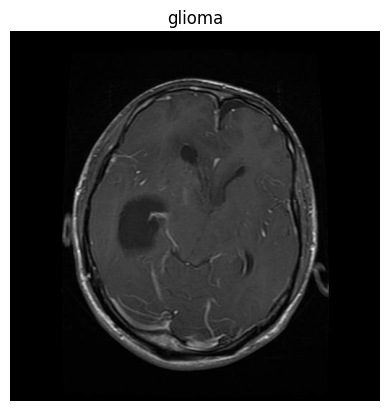

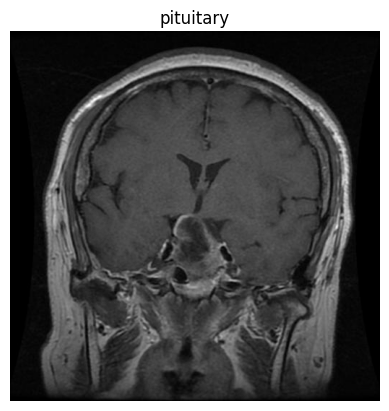

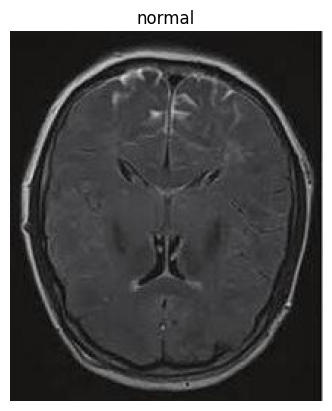

In [8]:
import os, random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 4 class folders ke paths
paths = {
    "meningioma": "/content/dataaset/Training/meningioma",
    "glioma": "/content/dataaset/Training/glioma",
    "pituitary": "/content/dataaset/Training/pituitary",
    "normal": "/content/dataaset/Training/notumor"
}

# Har class se 1 random image display
for label, folder in paths.items():
    img_name = random.choice(os.listdir(folder))       # ek random image
    img_path = os.path.join(folder, img_name)

    img = mpimg.imread(img_path)
    plt.imshow(img, cmap='gray')  # grayscale hai to cmap='gray'
    plt.title(label)
    plt.axis('off')
    plt.show()


# Taking  Dataset Into Chunks

In [9]:
# mini batch training ..
# this 250 - 250 dataset we  have assigned into
#  newly made "small datase " folder from
# "content/dataset/training" directory"
import os, random, shutil

classes = ["notumor", "pituitary", "meningioma", "glioma"]
original_base = "/content/dataaset/Training"
subset_base = "/content/small_dataaset"
os.makedirs(subset_base, exist_ok=True)

for cls in classes:
    os.makedirs(os.path.join(subset_base, cls), exist_ok=True)
    images = os.listdir(os.path.join(original_base, cls))
    random.seed(42)   
    selected = random.sample(images, 500)  # 250 images per class
    for img in selected:
        shutil.copy(os.path.join(original_base, cls, img),
                    os.path.join(subset_base, cls, img))


In [10]:
import os

subset_base = "/content/small_dataaset"
classes = ["notumor", "pituitary", "meningioma", "glioma"]

for cls in classes:
    path = os.path.join(subset_base, cls)
    count = len(os.listdir(path))
    print(f"{cls} images:", count)

notumor images: 500
pituitary images: 500
meningioma images: 500
glioma images: 500


# Train validation split

In [11]:
from sklearn.model_selection import train_test_split

train_dir = "/content/small_train"
val_dir   = "/content/small_val"

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

    images = os.listdir(os.path.join(subset_base, cls))
    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

    for img in train_imgs:
        shutil.copy(os.path.join(subset_base, cls, img),
                    os.path.join(train_dir, cls, img))
    for img in val_imgs:
        shutil.copy(os.path.join(subset_base, cls, img),
                    os.path.join(val_dir, cls, img))


In [12]:
import os

train_dir = "/content/small_train"
classes = ["notumor", "pituitary", "meningioma", "glioma"]

for cls in classes:
    path = os.path.join(train_dir, cls)
    count = len(os.listdir(path))
    print(f"{cls} train images:", count)


notumor train images: 400
pituitary train images: 400
meningioma train images: 400
glioma train images: 400


In [13]:
import os

val_dir = "/content/small_val"   # tumhara validation directory
classes = ["notumor", "pituitary", "meningioma", "glioma"]

for cls in classes:
    path = os.path.join(val_dir, cls)
    count = len(os.listdir(path))
    print(f"{cls} images in validation:", count)


notumor images in validation: 100
pituitary images in validation: 100
meningioma images in validation: 100
glioma images in validation: 100


# Loading the Dataset and processing

In [14]:
# Step 1: Imports
import tensorflow as tf
from tensorflow.keras import layers, models, Sequential
import matplotlib.pyplot as plt

# Step 2: Paths set karo (apne folder ke hisaab se)
train_dir = '/content/small_train'      # example: "dataset/train"
val_dir   = '/content/small_val'         # example: "dataset/val"

# Step 3: Modern way se dataset load karo (ImageDataGenerator ko bhool jao)
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=16,
    label_mode='categorical',    # agar 2 se zyada classes hain
    shuffle=True,
    seed=123
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=16,
    label_mode='categorical',
    shuffle=False
)

# Optional: Validation ko bhi cache kar do speed ke liye
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 1600 files belonging to 4 classes.
Found 400 files belonging to 4 classes.


# Defining Data Augmentation

In [15]:
# Step 4: Data Augmentation layers banao (ye GPU pe bhi fast chalti hain)
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

# Loading Pretrained Model

In [16]:
base_model = tf.keras.applications.EfficientNetB3(
    weights='imagenet',
    include_top=False,                                     
    input_shape=(224, 224, 3) 
)                             
                            



         # Means we are removing last layer of                              
         # image net ..last layer means
         # classifing or giving output probability
         # for classes ..we are removing because 
         # we do not want the probabiliy of imagenet
         # dataset. we just want to 
         # learn the faetures , edges from
         # other dataset . we turned off the last layer 
         # of this because we will use last layer (our custom layer)
         # for our dataset to tune the model 



# Defining  Callbacks 

In [17]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3),
    tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss")
]

# Patience  = 7 means ,  epoch = 7 ..its is threshhold. , if 
# there is no change in accuracy in next 7 epoch model will 
# be stopped from being trained.

#            ReduceLROnPlateau =  If from first 3 epoch
#                                 there is no major change
#                   trainig accuracy or validation then ...it will
#                   halfen the assigned the learning rate ...
#                   if there is still a problem in next 4 epoch
#                   means there is no major change in next 4 epochs 
#                   then ..it will copletely stopped the model 
#                   from being train .



# Model Architecture (Top Layers)

In [18]:
num_classes = len(os.listdir(train_dir)) # here we are defining number 
                                         # of classes . 


  
# our  convolution architeture.
# our last layer which i  have to train .

model = Sequential([
    layers.Input(shape=(224,224,3)),
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,       # our pretrained model base layer added here
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax') 
])

# code :
     # layers.Dense(num_classes, activation='softmax') 

# explanation : 

#  Last layer → this  layer is known as last layer :
# this  is ihe ouput  layer of my dataset ..

# This last layer roughly decides which class an image belongs to.
# Basically, it maps the features 
# extracted by the base model (edges, textures, patterns)
# to the class labels of your dataset.
# During the first 5 epochs, 
# it only performs this initial adjustment, 
# serving as a basic mapping between features and labels.



# 512 nuerons means 512 diffrent observaton in just 
# one image.


# important 
          # we can  replace num_classes to 4.


# Compiling and Training The Last Layer.

In [19]:
base_model.trainable = False # our pretrained base model layer
                             # which will not be updated while 
                             # compiling

model.compile(         
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

   # Here we have done base model(efficientNet B3)
   # false Because we do not want retrain the 
   # the base model or update. 
   # it already trained and have 
   # the Knowledges of Features , edges on Millions of images 
   # Dataset. So that why we turned Base Model false .

 # in  inside our model base model is already included 

# Fitting The Last Layer

In [20]:
history = model.fit(train_ds, 
                    validation_data=val_ds,
                    epochs=5, 
                    callbacks=callbacks)

# here we are fitting the compilation.
#  in this we have  already freezed the base model 


# here we have given only 5 epochs because
# This last layer roughly decides which class an image belongs to.

# Basically, it maps the features extracted
# by the base model (edges, textures, patterns) 
# to the class labels of your dataset.

# During the first 5 epochs,
# it only performs this initial adjustment,
# serving as a basic mapping between features and labels.

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 74s 622ms/step - accuracy: 0.4231 - loss: 1.5094 - val_accuracy: 0.4325 - val_loss: 1.2962 - learning_rate: 5.0000e-04
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 55s 554ms/step - accuracy: 0.4069 - loss: 1.5364 - val_accuracy: 0.4750 - val_loss: 1.2668 - learning_rate: 5.0000e-04
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 55s 549ms/step - accuracy: 0.4194 - loss: 1.4324 - val_accuracy: 0.4025 - val_loss: 1.2382 - learning_rate: 5.0000e-04
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 53s 532ms/step - accuracy: 0.4419 - loss: 1.3809 - val_accuracy: 0.3800 - val_loss: 1.1499 - learning_rate: 5.0000e-04
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 51s 506ms/step - accuracy: 0.4588 - loss: 1.3666 - val_accuracy: 0.4775 - val_loss: 1.1216 - learning_rate: 5.0000e-04


# Fine-Tuning (Unfreeze Last Layers)

In [21]:
base_model.trainable = True
fine_tune_at = 100 # here we are freezing the first 100 layer 
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

fine_tune_at = 100 

  # exlanation:
# We are freezing the first 100 layers of the base model because 
# these bottom layers detect simple features (edges, colors, textures) 
# which are already learned and do not need retraining.

# Now, only the top layers of the base model will be trainable.
# These top layers detect complex patterns, and they will adapt to 
# our dataset to recognize its specific complex features.
# We assigned these top layers because they already have knowledge 
# of complex patterns from pre-training and can easily adjust 
# to our dataset.

# final compilation for last layer 

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# final fitting for our last  layer 

In [23]:
fine_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

# here we are training the top layers 
# of our model ....this top layers 
# is of base model (pretrained model)
# this layer is already have knowledge 
# of comoplex features .


Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.5750 - loss: 1.2067 - val_accuracy: 0.3700 - val_loss: 1.5935 - learning_rate: 1.0000e-04
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.6762 - loss: 0.8458 - val_accuracy: 0.3750 - val_loss: 1.2937 - learning_rate: 1.0000e-04
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.7044 - loss: 0.8063 - val_accuracy: 0.6475 - val_loss: 0.8706 - learning_rate: 1.0000e-04
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.7450 - loss: 0.6803 - val_accuracy: 0.7425 - val_loss: 0.7087 - learning_rate: 1.0000e-04
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.7563 - loss: 0.6248 - val_accuracy: 0.8050 - val_loss: 0.5294 - learning_rate: 1.0000e-04
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.7894 - loss: 0.5166 - val_accuracy: 0.8100 - val_loss: 0.4995 - learning_rate: 1.0000e-04
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - acc

# Loading Test Data

In [24]:
test_dir = "/content/dataaset/Testing"

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32,
    shuffle=False  # test me shuffle mat karo
)


Found 1311 files belonging to 4 classes.


In [25]:
import os

test_dir = "/content/dataaset/Testing"
classes = ["notumor", "pituitary", "meningioma", "glioma"]

for cls in classes:
    path = os.path.join(test_dir, cls)   # yahan test_dir lagana hoga
    count = len(os.listdir(path))
    print(f"{cls} images:", count)


notumor images: 405
pituitary images: 300
meningioma images: 306
glioma images: 300


In [26]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# test_datagen = ImageDataGenerator(rescale=1./255)

# test_generator = test_datagen.flow_from_directory(
#     "/content/small_test_dataset",
#     target_size=(224,224),
#     batch_size=1,
#     class_mode='categorical',
#     shuffle=False,
#     classes=["notumor", "pituitary", "meningioma", "glioma"]  # TRAIN order
# )

In [27]:
model = tf.keras.models.load_model("best_model.keras")

In [28]:
test_dir = "/content/small_test_dataset"

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224,224),
    batch_size=16,
    label_mode='categorical',
    shuffle=False,          # important
    seed=123
)

test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Predictions
preds = model.predict(test_ds)
pred_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(np.concatenate([y for x, y in test_ds], axis=0), axis=1)

accuracy = np.mean(pred_classes == true_classes) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

Found 1311 files belonging to 4 classes.
82/82 ━━━━━━━━━━━━━━━━━━━━ 34s 384ms/step
Test Accuracy: 88.41%


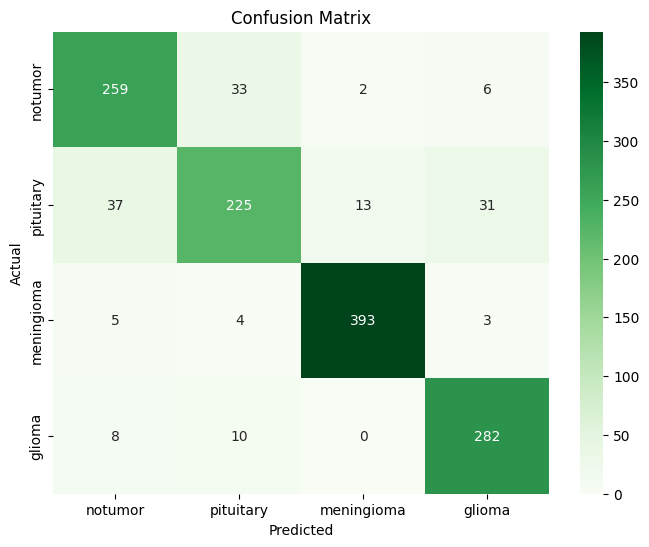

In [39]:

class_names = ["notumor", "pituitary", "meningioma", "glioma"]

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [44]:
class_names = ["notumor", "pituitary", "meningioma", "glioma"]

from sklearn.metrics import classification_report

print(classification_report(true_classes, pred_classes, target_names=class_names))



              precision    recall  f1-score   support

     notumor       0.84      0.86      0.85       300
   pituitary       0.83      0.74      0.78       306
  meningioma       0.96      0.97      0.97       405
      glioma       0.88      0.94      0.91       300

    accuracy                           0.88      1311
   macro avg       0.88      0.88      0.88      1311
weighted avg       0.88      0.88      0.88      1311



In [46]:
import pandas as pd
import numpy as np

# Tumhare class names
class_names = ["notumor", "pituitary", "meningioma", "glioma"]

#  Model predictions
pred_probs = model.predict(test_ds)
pred_classes = np.argmax(pred_probs, axis=1)

#  True labels
true_classes = np.concatenate([y for x, y in test_ds], axis=0)
true_classes = np.argmax(true_classes, axis=1)

#  Convert indices to class names
true_labels = [class_names[i] for i in true_classes]
pred_labels = [class_names[i] for i in pred_classes]

#  Create DataFrame
df = pd.DataFrame({
    "True_Label": true_labels,
    "Predicted_Label": pred_labels
})

#  Save CSV
df.to_csv("predictions.csv", index=False)

print("CSV file saved as predictions.csv")


82/82 ━━━━━━━━━━━━━━━━━━━━ 29s 354ms/step
CSV file saved as predictions.csv


In [47]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

# Class names
class_names = ["notumor", "pituitary", "meningioma", "glioma"]

# True labels
true_classes = np.concatenate([y for x, y in test_ds], axis=0)
true_classes = np.argmax(true_classes, axis=1)

# Model predictions
pred_probs = model.predict(test_ds)
pred_classes = np.argmax(pred_probs, axis=1)

# Convert numeric labels to class names
true_labels = [class_names[i] for i in true_classes]
pred_labels = [class_names[i] for i in pred_classes]

# Classification report as dictionary
report_dict = classification_report(true_classes, pred_classes, target_names=class_names, output_dict=True)

# Create DataFrame for metrics
metrics_df = pd.DataFrame(report_dict).transpose()

# Save classification metrics to CSV
metrics_df.to_csv("classification_metrics.csv", index=True)
print("Classification metrics saved as classification_metrics.csv")



82/82 ━━━━━━━━━━━━━━━━━━━━ 28s 338ms/step
Classification metrics saved as classification_metrics.csv
